<a href="https://colab.research.google.com/github/Yogesh11-12/Spam-Classification/blob/main/Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# List .txt files in the root.
#
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
listed = drive.ListFile({'q': "title contains '.txt' and 'root' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df=pd.read_csv('/content/spam.csv',delimiter=',',encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ham     4825
spam     747
Name: v1, dtype: int64

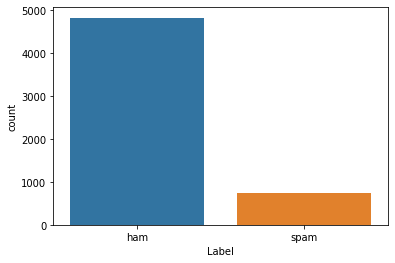

In [10]:
sns.countplot(df.v1)
plt.xlabel('Label')
df.v1.value_counts()

In [18]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
x=df.v2
y=df.v1
Y=le.fit_transform(y)
Y=Y.reshape(-1,1)
Y

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [19]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(x,Y,test_size=0.2)

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
max_words=1000
max_len=150
tok=Tokenizer(num_words=max_words)
tok.fit_on_texts(train_x)
sequences=tok.texts_to_sequences(train_x)
sequence_matrix=sequence.pad_sequences(sequences,maxlen=max_len)

In [27]:
from keras.layers import Dense,Embedding,Input,Activation,LSTM,Dropout
from keras import Model


In [44]:
def RNN():
  input=Input(name='inputs',shape=[max_len])
  layer1=Embedding(max_words,50,input_length=max_len)(input)
  layer2=LSTM(64)(layer1)
  layer3=Dense(256,name='fc1')(layer2)
  layer4=Activation('relu')(layer3)
  layer5=Dropout(0.4)(layer4)
  layer6=Dense(1,name='Outputlayer')(layer5)
  layer7=Activation('sigmoid')(layer6)
  model=Model(inputs=input,Outputs=layer7)
  return model

In [61]:
from keras import Sequential
my_model=Sequential()
my_model.add(Input(shape=[max_len]))
my_model.add(Embedding(max_words,50,input_length=max_len))
my_model.add(LSTM(64))
my_model.add(Dense(256,activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(1,activation='sigmoid'))

In [62]:
my_model.summary()
my_model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['Accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________________


In [71]:
from keras.callbacks import EarlyStopping
model_hist=my_model.fit(sequence_matrix,train_y,batch_size=120,epochs=6,validation_split=0.2,callbacks=[EarlyStopping(patience=5)])

Epoch 1/6
30/30 [==============================] - 5s 182ms/step - loss: 0.0082 - accuracy: 0.0690 - val_loss: 0.0845 - val_accuracy: 0.0740
Epoch 2/6
30/30 [==============================] - 5s 182ms/step - loss: 0.0059 - accuracy: 0.0757 - val_loss: 0.0989 - val_accuracy: 0.0684
Epoch 3/6
30/30 [==============================] - 5s 181ms/step - loss: 0.0050 - accuracy: 0.0777 - val_loss: 0.0956 - val_accuracy: 0.0874
Epoch 4/6
30/30 [==============================] - 5s 183ms/step - loss: 0.0062 - accuracy: 0.0948 - val_loss: 0.0997 - val_accuracy: 0.0953
Epoch 5/6
30/30 [==============================] - 5s 182ms/step - loss: 0.0027 - accuracy: 0.1032 - val_loss: 0.1304 - val_accuracy: 0.0998
Epoch 6/6
30/30 [==============================] - 5s 181ms/step - loss: 0.0025 - accuracy: 0.0985 - val_loss: 0.1161 - val_accuracy: 0.1009


In [72]:
test_sequence=tok.texts_to_sequences(test_x)
test_sequence_matrix=sequence.pad_sequences(test_sequence,maxlen=max_len)

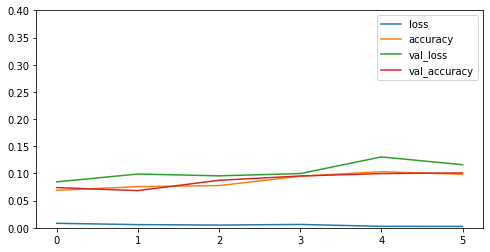

In [73]:
pd.DataFrame(model_hist.history).plot(figsize=(8,4))
plt.gca().set_ylim(0,0.4)
plt.show()

In [74]:
accr=my_model.evaluate(test_sequence_matrix,test_y)


35/35 [==============================] - 1s 22ms/step - loss: 0.0725 - accuracy: 0.0987


In [97]:
text_data=['hi dear how are you']
text_spam=['Congrats you win cash prize']

In [93]:
def text_to_matrix(data):
  txts=tok.texts_to_sequences(text_data)
  txts=sequence.pad_sequences(txts,maxlen=max_len)
  return txts

In [98]:
def predict(data):
  txts=tok.texts_to_sequences(data)
  txts=sequence.pad_sequences(txts,maxlen=max_len)
  predict=np.round(my_model.predict(txts))
  dict={0:'Not_spam',1:'Spam'}
  y=predict.flatten()
  y_pred=print(dict[y[0]])
  return y_pred

In [99]:
predict(text_data)

Not_spam


In [100]:
predict(text_spam)

Spam
